In [15]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
import matplotlib.lines as mlines
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
import threading
from copy import deepcopy
from sys import stdout

### Hỗn hợp

In [16]:
honhop_folder = "data2/Honhop"
data_frames = []
file_names = []
for index, file_name in enumerate(os.listdir(honhop_folder)):
    if file_name.endswith(".CSV"):  # Check if the file is a CSV
        file_path = os.path.join(honhop_folder, file_name)
        df = pd.read_csv(file_path, header=None).values
        if index == 0:
            data_frames.append(df[:, 0].reshape(1, -1))
        data_frames.append(df[:, 1].reshape(1, -1))
        file_names.append(file_name)
honhop = pd.DataFrame(np.concatenate(data_frames[1:]), columns=list(data_frames[0]))
honhop.columns = ['_'.join(map(str, col)) for col in honhop.columns]
honhop["File name"] = file_names
honhop["Type"] = honhop["File name"].str.split("-", expand=True)[0].str[0]
honhop_deriv = savgol_filter(honhop.iloc[:, :-2], window_length=25, polyorder=5, deriv=2)
honhop.iloc[:, :-2] = honhop_deriv

### Rễ

In [17]:
re_folder = "data2/Re"
data_frames = []
file_names = []
for index, file_name in enumerate(os.listdir(re_folder)):
    if file_name.endswith(".CSV"):  # Check if the file is a CSV
        file_path = os.path.join(re_folder, file_name)
        df = pd.read_csv(file_path, header=None).values
        if index == 0:
            data_frames.append(df[:, 0].reshape(1, -1))
        data_frames.append(df[:, 1].reshape(1, -1))
        file_names.append(file_name)
re = pd.DataFrame(np.concatenate(data_frames[1:]), columns=list(data_frames[0]))
re.columns = ['_'.join(map(str, col)) for col in re.columns]
re["File name"] = file_names
re["Type"] = re["File name"].str.split("-", expand=True)[0].str[0]
re_deriv = savgol_filter(re.iloc[:, :-2], window_length=25, polyorder=5, deriv=2)
re.iloc[:, :-2] = re_deriv

### Thân

In [18]:
than_folder = "data2/Than"
data_frames = []
file_names = []
for index, file_name in enumerate(os.listdir(than_folder)):
    if file_name.endswith(".CSV"):  # Check if the file is a CSV
        file_path = os.path.join(than_folder, file_name)
        df = pd.read_csv(file_path, header=None).values
        if index == 0:
            data_frames.append(df[:, 0].reshape(1, -1))
        data_frames.append(df[:, 1].reshape(1, -1))
        file_names.append(file_name)
than = pd.DataFrame(np.concatenate(data_frames[1:]), columns=list(data_frames[0]))
than.columns = ['_'.join(map(str, col)) for col in than.columns]
than["File name"] = file_names
than["Type"] = than["File name"].str.split("-", expand=True)[0].str[0]
than_deriv = savgol_filter(than.iloc[:, :-2], window_length=25, polyorder=5, deriv=2)
than.iloc[:, :-2] = than_deriv

In [19]:
data = pd.concat([honhop, re, than], axis=0)
data.shape

(119, 1871)

In [20]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(data["Type"])

In [21]:
X = data.iloc[:, :-2]
wl = X.columns
X = savgol_filter(X, 25,  polyorder=5, deriv = 1)

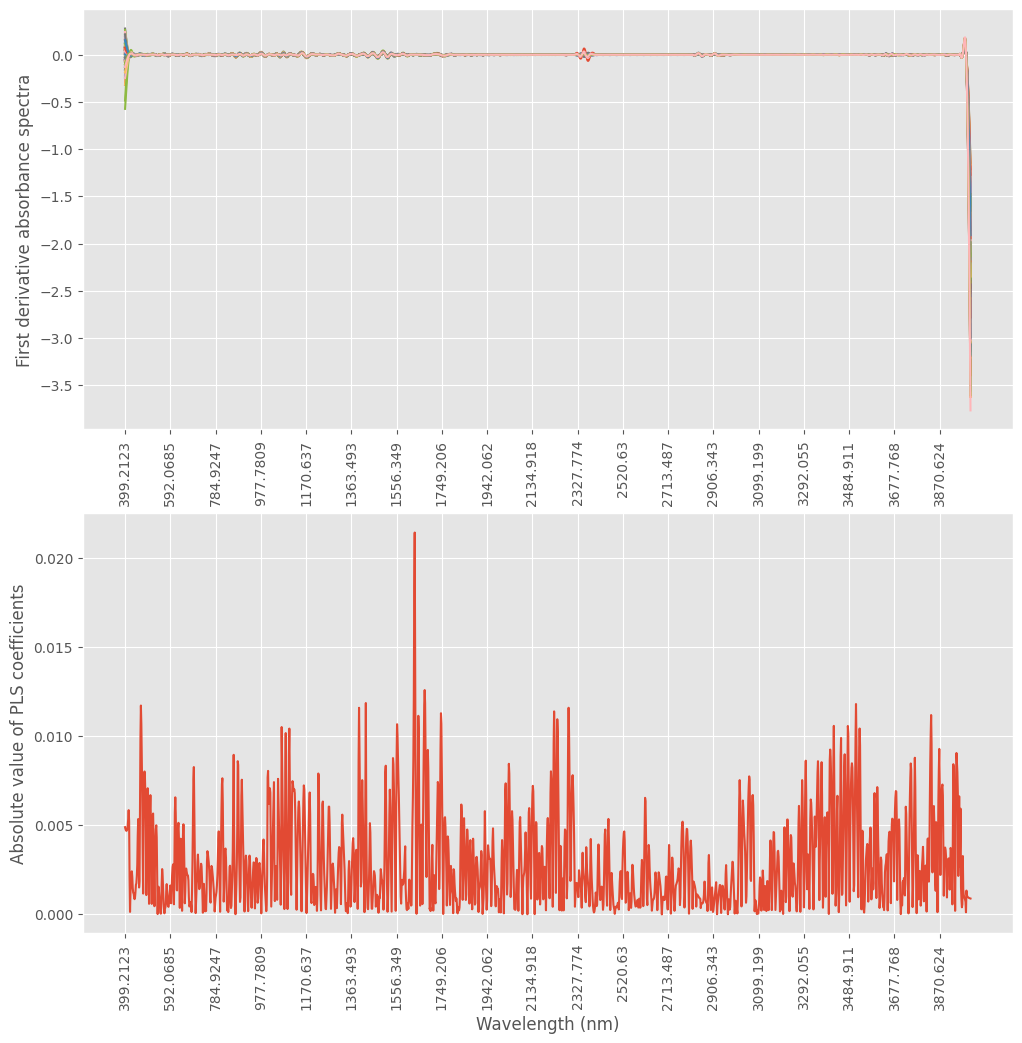

In [22]:
from sklearn.cross_decomposition import PLSRegression
pls = PLSRegression(8)
pls.fit(X, y)


# print(np.abs(pls.coef_)reshape(-1,1))
plt.figure(figsize=(12,12))
with plt.style.context(('ggplot')):
    ax1 = plt.subplot(211)
    plt.plot(wl, X.T)
    plt.ylabel('First derivative absorbance spectra')
    plt.gca().set_xticks(np.arange(0, len(wl), 100))
    plt.xticks(rotation=90)
 
    ax2 = plt.subplot(212, sharex=ax1)
    plt.plot(wl, np.abs(pls.coef_).reshape(-1,1))
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Absolute value of PLS coefficients')
    plt.gca().set_xticks(np.arange(0, len(wl), 100))
    plt.xticks(rotation=90)
 
    plt.show()

In [23]:
# Get the list of indices that sorts the PLS coefficients in ascending order 
# of the absolute value
sorted_ind = np.argsort(list(np.abs(pls.coef_)))
# Sort spectra according to ascending absolute value of PLS coefficients
Xc = X[:,sorted_ind[0]]

In [24]:
Xc.shape

(119, 1869)

In [25]:
def calculate_mse(X, y, n_comp, loss):
    pls1 = PLSRegression(n_components=n_comp)
    pls1.fit(X, y)
    
    # Indices of sort spectra according to ascending absolute value of PLS coefficients
    sorted_ind = np.argsort(list(np.abs(pls1.coef_)))[0]

    # Sort spectra accordingly 
    Xc = X[:,sorted_ind]

    # Discard one wavelength at a time of the sorted spectra,
    # regress, and calculate the MSE cross-validation
    for j in range(Xc.shape[1]-(n_comp)):

        pls2 = PLSRegression(n_components=n_comp)
        pls2.fit(Xc[:, j:], y)
        loss[j] = np.mean(1 - cross_val_score(pls2, Xc[:, j:], y, cv=5))
    print("done")
    # comp = 100*(i+1)/(max_comp)
    # stdout.write("\r%d%% completed" % comp)
    # stdout.flush()

In [26]:
def calculate_loss(n_comp, Xc, y, j, loss):
    pls2 = PLSRegression(n_components=n_comp)
    pls2.fit(Xc[:, j:], y)
    loss[j] = np.mean(1 - cross_val_score(pls2, Xc[:, j:], y, cv=5))

In [27]:
def pls_variable_selection(X, y, max_comp):
    
    # Define MSE array to be populated
    # mse = np.zeros((max_comp,X.shape[1]))
    nrows = max_comp
    ncols = X.shape[1]
    mse=[*map(lambda a: [a]*ncols,[0]*nrows)]
    # Loop over the number of PLS components
    for i in range(max_comp):
    #     t = threading.Thread(target=calculate_mse, args = (deepcopy(X), deepcopy(y), i + 1, mse[i]))
    #     threads.append(t)
    #     t.start()
    # for t in threads:
    #     t.join()
        # Regression with specified number of components, using full spectrum
        pls1 = PLSRegression(n_components=i+1)
        pls1.fit(X, y)
        
        # Indices of sort spectra according to ascending absolute value of PLS coefficients
        sorted_ind = np.argsort(list(np.abs(pls1.coef_)))[0]
 
        # Sort spectra accordingly 
        Xc = X[:,sorted_ind]
        threads = []
        # Discard one wavelength at a time of the sorted spectra,
        # regress, and calculate the MSE cross-validation
        for j in range(Xc.shape[1]-(i+1)):
            t = threading.Thread(target=calculate_loss, args = (i + 1,deepcopy(X), deepcopy(y), j, mse[i]))
            threads.append(t)
            t.start()
        for t in threads:
            t.join()
            # pls2 = PLSRegression(n_components=i+1)
            # pls2.fit(Xc[:, j:], y)
            # mse[i,j] = np.mean(1 - cross_val_score(pls2, Xc[:, j:], y, cv=5))
     
        comp = 100*(i+1)/(max_comp)
        stdout.write("\r%d%% completed" % comp)
        stdout.flush()
    stdout.write("\n")
    print(mse)
    # # Calculate and print the position of minimum in MSE
    mseminx,mseminy = np.where(mse==np.min(mse[np.nonzero(mse)]))
 
    print("Optimised number of PLS components: ", mseminx[0]+1)
    print("Wavelengths to be discarded ",mseminy[0])
    print('Optimised MSEP ', mse[mseminx,mseminy][0])
    # plt.imshow(mse, interpolation=None)
    # plt.show()
 
 
    # Calculate PLS with optimal components and export values
    pls = PLSRegression(n_components=mseminx[0]+1)
    pls.fit(X, y)
        
    sorted_ind = np.argsort(list(np.abs(pls.coef_)))[0]
    Xc = X[:,sorted_ind]
 
    return(Xc[:,mseminy[0]:],mseminx[0]+1,mseminy[0], sorted_ind)

In [28]:
opt_Xc, ncomp, wav, sorted_ind = pls_variable_selection(X, y, 15)

100% completed
[[3.117461230323923, 3.11677022242079, 3.1160614027487896, 3.115340519818807, 3.1146147981281103, 3.1138947631841942, 3.113198165062249, 3.1125595896535327, 3.1120573349684877, 3.111890600282982, 3.112262089756599, 3.1118552459842284, 3.110844768150216, 3.1096259342850345, 3.1082135587467876, 3.106643169193846, 3.1049635686494925, 3.1033218502119544, 3.1022503484317827, 3.1016547855014847, 3.100773968869919, 3.09971266748522, 3.09864758608396, 3.097652186834541, 3.096749994502873, 3.0959566336269524, 3.095183482098887, 3.094130986231684, 3.0925298538143893, 3.0904811233196563, 3.0887922743330485, 3.088412895214439, 3.08903526883671, 3.090310436276085, 3.0922965178397988, 3.0952600896976996, 3.0980749744844465, 3.0986869852778804, 3.097232518985946, 3.094781904853965, 3.092035341451743, 3.0901548657734863, 3.090412730772895, 3.0926243627674617, 3.095811882009823, 3.0993738371716786, 3.1027559265672098, 3.1054093569098304, 3.1065853097367735, 3.106546939615928, 3.106645403

TypeError: list indices must be integers or slices, not tuple